### Importing Required Libraries 

In [1]:
#Importing the required libraries
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

from pprint import pprint
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from pyearth import Earth
from sklearn.svm import SVR
from pygam import LinearGAM
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

### Importing the Dataset & Classes

In [2]:
# Read & Display data
data = pd.read_csv("C:/Users/Aman.aggarwal/Documents/Exelon/Chem Sampling/wine.csv")
data.head()

,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
class Data:
    def __init__(self,df, pfeatures, target, split):
        '''
        function to intialise the class object 
        @params
        df = dataframe containing all the data with target variable 
        pfeatures=  list of columns other than target to do feature selection
        target = target variable in list
        split = by what value data to be splitted for holdout sample
        '''
        self.df = df
        self.pfeatures = pfeatures
        self.target = target 
        self.split = split
        X = self.df[pfeatures]
        print(X.shape)
        y = self.df[self.target]
        print(y.shape)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=self.split, random_state=42)
        print(self.X_train.shape, self.X_test.shape)
        print(self.y_train.shape, self.y_test.shape)
        

In [4]:
#Assigning the dependent & independent variable
pfeatures = ['Malic.acid', 'Ash', 'Acl', 'Mg', 'Phenols',
             'Flavanoids', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 'Hue', 'OD', 'Proline']
target=['Alcohol']
split = 0.20

In [5]:
r= Data(data, pfeatures, target, split)

(178, 12)
(178, 1)
(142, 12) (36, 12)
(142, 1) (36, 1)


In [78]:
class Regression_model(Data):
    
    def __init__(self, Data):
        '''
        function to intialise the class object 
        '''
        self.df = Data.df
        self.pfeatures = Data.pfeatures
        self.target = Data.target
        self.X_train = Data.X_train
        self.X_test = Data.X_test
        self.y_train = Data.y_train
        self.y_test = Data.y_test
        self.params = {}
        self.model_result_df = pd.DataFrame()
        
    # calculate mape scores
    def mean_absolute_percentage_error(self, y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # calculate rmse scores
    def rmse(self, pred_test, y_test):
    
        return np.sqrt(((pred_test - y_test) ** 2).mean())
    
    def plot(self, predictions1):
        plt.figure(figsize=(6, 5))
        with plt.style.context('ggplot'):
            y_test, predictions = np.array(self.y_test), np.array(predictions1)
            y_test, predictions = y_test.ravel(), predictions.ravel()
            plt.scatter(y_test, predictions, color='red')
            plt.plot(y_test, y_test, '-g', label='Expected regression line')
            z = np.polyfit(y_test, predictions, 1)
            plt.plot(np.polyval(z, y_test), y_test, color='blue', label='Predicted regression line')
            plt.xlabel('Actual')
            plt.ylabel('Predicted')
            plt.legend()
            plt.plot()
    
    def fit_model(self, estimator, param = None):
        '''
        function for fitting the model and accepts estimator
        as parameter which is sklearn ML algorithm object 
        '''
        # fit a model
        lm = estimator
        self.param = param
        res = not bool(self.param)
        if(res == False):
            lm.set_params(**param)
            model = lm.fit(self.X_train, self.y_train)
        else:
            model = lm.fit(self.X_train, self.y_train)
        
        return model
    
    def train_predict(self, fitted_model):
        '''
        function for doing the prediction on fitted model and accepts
        fitted_model as parameter
        Returns the predicted values for train and test dataset
        '''
        train_predictions = fitted_model.predict(self.X_train)
        predictions = fitted_model.predict(self.X_test)
        
        return train_predictions, predictions
    
    def model_eval(self, train_predictions, predictions, model_name):
        '''
        function for evaluating the model and accepts predictions
        as parameter
        Returns the dataframe with mse, rmse, mae, mape & r2
        '''
        n = len(self.y_train)
        mse_train = mean_squared_error(self.y_train, train_predictions)
        rmse_train = self.rmse(self.y_train, train_predictions.reshape(n,1))
        mae_train = mean_absolute_error(self.y_train, train_predictions)
        mape_train = self.mean_absolute_percentage_error(self.y_train, train_predictions)
        r2_train = r2_score(self.y_train, train_predictions)

        m = len(predictions)
        mse_test = mean_squared_error(self.y_test, predictions)
        rmse_test = self.rmse(self.y_test, predictions.reshape(m,1))
        mae_test = mean_absolute_error(self.y_test, predictions)
        mape_test = self.mean_absolute_percentage_error(self.y_test, predictions)
        r2_test = r2_score(self.y_test, predictions)
        
        temp = pd.DataFrame({"MODEL_NAME" : model_name,
                             "TRAIN_MSE" : [mse_train],
                             "TRAIN_RMSE": rmse_train,
                             "TRAIN_MAE" : [mae_train],
                             "TRAIN_MAPE": mape_train,
                             "TRAIN_R2": [r2_train],
                             "TEST_MSE" : [mse_test],
                             "TEST_RMSE": rmse_test,
                             "TEST_MAE" : [mae_test],
                             "TEST_MAPE": mape_test,
                             "TEST_R2": [r2_test]})
        return temp
    
    def store_res(self,  temp):
        '''
        function for storing evaluation of the model and accepts 
        dataframe having evaluated scores with model name as parameter
        Returns the whole dataframe with different models stored
        '''
        self.model_result_df=self.model_result_df.append(temp)
        
        return self.model_result_df
    
    def randomized_search(self, estimator, random_grid, iterations, cv):
        '''
        function for randomized search and accepts following as parameter:
        estimator : sklearn ML algorithm object 
        random_grid : Dictionary of the parameters to be used for random search
        iterations : Number of iterations to be performed
        cv : Number of cross validations
        '''
        rs = estimator
        model = RandomizedSearchCV(estimator = rs, param_distributions = random_grid, n_iter = iterations, cv = cv,
                                      verbose=5, scoring='neg_mean_absolute_error', random_state=1234, n_jobs = -1)
        model.fit(self.X_train, self.y_train)
        return model
    
    def grid_search(self, estimator, random_grid, cv):
        '''
        function for grid search and accepts following as parameter:
        estimator : sklearn ML algorithm object 
        random_grid : Dictionary of the parameters to be used for grid search
        cv : Number of cross validations
        '''
        rs = estimator
        model = GridSearchCV(estimator = rs, param_grid = random_grid, cv = cv,
                                      verbose=5, scoring='neg_mean_absolute_error', n_jobs = -1)
        model.fit(self.X_train, self.y_train)
        return model



In [79]:
m = Regression_model(r)

### Estimators for baseline results

In [77]:
#Defining the estimators or regressors
estimator1 = linear_model.LinearRegression() #Linear
estimator2 = linear_model.RANSACRegressor()  #Robust
estimator3 = HuberRegressor()                #Robust
estimator4 = linear_model.Lasso(alpha=0.1)   #Lasso
estimator5 = linear_model.Ridge(alpha=0.1)   #Ridge
estimator6 = linear_model.ElasticNet(alpha = 0.5,random_state = 0)  #ElasticNEt
estimator7 = PLSRegression(n_components=2) #PLS
estimator8 = linear_model.Lars(n_nonzero_coefs=1)  #LARS
regressor = xgb.XGBRegressor(n_estimators=100, reg_lambda=1, gamma=0, max_depth=3) #XGB
regressor2 = RandomForestRegressor(max_depth=2, random_state=0) #RF
regressor3 = DecisionTreeRegressor(max_depth=2) #DecisionTree
regressor4 = Earth(max_terms=500, max_degree=1) #MARS #(max_degree=2, penalty=1.0, minspan_alpha = 0.01, endspan_alpha = 0.01, endspan=5)
regressor5 = LinearGAM() #GAM
regressor6 = SVR(C=1.0, epsilon=0.2)  #SVR
regressor7 = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=10) #LGBM

### Baseline 

In [80]:
#Assigning the estimator
lgbm_base = lgb.LGBMRegressor()

#Fiiting the model
obj = m.fit_model(lgbm_base)

#Getting predcitions for the training data using fitted model
train_prediction_res, predcition_result = m.train_predict(obj)

#Evaluating the model
eval_res = m.model_eval(train_prediction_res, predcition_result, 'LGB_Baseline')
eval_res

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
Alcohol,LGB_Baseline,0.072799,0.269813,0.203052,6.756318,0.890996,0.171711,0.41438,0.33518,6.411252,0.712394


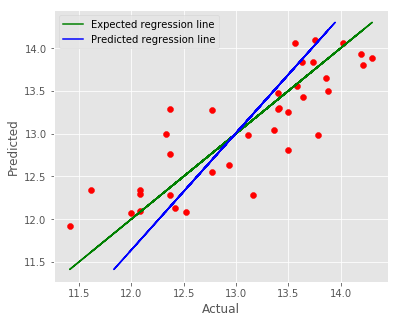

In [81]:
#Plotting the actual vs fitted
m.plot(predcition_result)

In [82]:
#Storing the model results
m.store_res(eval_res)

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
Alcohol,LGB_Baseline,0.072799,0.269813,0.203052,6.756318,0.890996,0.171711,0.41438,0.33518,6.411252,0.712394


In [83]:
#Getting the results
result = m.model_result_df.reset_index()
result.drop(['index'], inplace = True, axis = 1)
result

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,LGB_Baseline,0.072799,0.269813,0.203052,6.756318,0.890996,0.171711,0.41438,0.33518,6.411252,0.712394


In [84]:
obj.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### Randomized  Search

In [85]:
####INitialising the parameters to be passed as dictionary

importance_type = ['split', 'gain']
max_bin  = [100, 200, 250, 300, 500]

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 3000, num = 20)]

# Number of features to consider at every split
learning_rate = [x for x in np.linspace(start = 0.01, stop = 0.3, num = 10)]

# Maximum number of levels in tree
max_depth = [-1, 3, 5, 7, 10, 12, 15, 17, 20]

# Minimum number of samples required to split a node
num_leaves = [int(x) for x in np.linspace(10, 60, num = 15)]

# Minimum number of samples required at each leaf node
loss_function = ["MAE", "RMSE"]

# Method of selecting samples for training each tree
min_split_gain  = [0, 1,2,3]

eval_metric = ["RMSE", "MAE"]

tree_learner = ['voting','serial']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'importance_type': importance_type,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'num_leaves': num_leaves,
               'min_split_gain ': min_split_gain ,
              'tree_learner': tree_learner,
              'max_bin': max_bin}

#pprint(random_grid)

In [86]:
#Assigning the estimator
estimator1 = lgb.LGBMRegressor(silent = False)

#Calling function for randomized search
obj2 = m.randomized_search(estimator1, random_grid, 150, 2)

Fitting 2 folds for each of 150 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.7min


[LightGBM] [Warning] min_split_gain is set=0.0, min_split_gain= will be ignored. Current value: min_split_gain=0.0
[LightGBM] [Warning] Unknown parameter: 3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_split_gain is set=0.0, min_split_gain= will be ignored. Current value: min_split_gain=0.0
[LightGBM] [Warning] Unknown parameter: 3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 478
[LightGBM] [Info] Number of data points in the train set: 142, number of used features: 12
[LightGBM] [Info] Start training from score 12.979085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.8min finished


In [87]:
obj2.best_params_

{'tree_learner': 'voting',
 'num_leaves': 31,
 'n_estimators': 100,
 'min_split_gain ': 3,
 'max_depth': 17,
 'max_bin': 100,
 'learning_rate': 0.042222222222222223,
 'importance_type': 'gain'}

In [88]:
#Assigning the estimator
lgbm_base = lgb.LGBMRegressor()

#Fiiting the model using the best params from randomized search
obj = m.fit_model(lgbm_base, obj2.best_params_)

#Getting predcitions for the training data using fitted model
train_prediction_res, predcition_result = m.train_predict(obj)

#Evaluating the model
eval_res = m.model_eval(train_prediction_res, predcition_result, 'LGB_RS')
eval_res

[LightGBM] [Warning] min_split_gain is set=0.0, min_split_gain= will be ignored. Current value: min_split_gain=0.0
[LightGBM] [Warning] Unknown parameter: 3
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
Alcohol,LGB_RS,0.142351,0.377295,0.291462,6.566637,0.786853,0.148358,0.385173,0.312282,6.309531,0.751509


In [89]:
#Storing the model results
m.store_res(eval_res)

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
Alcohol,LGB_Baseline,0.072799,0.269813,0.203052,6.756318,0.890996,0.171711,0.414380,0.335180,6.411252,0.712394
Alcohol,LGB_RS,0.142351,0.377295,0.291462,6.566637,0.786853,0.148358,0.385173,0.312282,6.309531,0.751509


### Grid Search 

In [90]:
####Initialising the parameters to be passed as dictionary
importance_type = ['gain']
max_bin  = [200]

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 5)]

# Number of features to consider at every split
learning_rate = [x for x in np.linspace(start = 0.03, stop = 0.05, num = 4)]

# Maximum number of levels in tree
max_depth = [14, 16, 17, 19]

# Minimum number of samples required to split a node
num_leaves = [int(x) for x in np.linspace(40, 60, num = 4)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'importance_type': importance_type,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'num_leaves': num_leaves,
              'max_bin': max_bin}

pprint(random_grid)

{'importance_type': ['gain'],
 'learning_rate': [0.03, 0.03666666666666667, 0.043333333333333335, 0.05],
 'max_bin': [200],
 'max_depth': [14, 16, 17, 19],
 'n_estimators': [50, 162, 275, 387, 500],
 'num_leaves': [40, 46, 53, 60]}


In [91]:
#Assigning the estimator
estimator1 = lgb.LGBMRegressor()

#Calling the grid search function
obj3 = m.grid_search(estimator1, random_grid, 2)

Fitting 2 folds for each of 320 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:    8.6s finished


In [92]:
#Assigning the estimator
lgbm_base = lgb.LGBMRegressor(tree_learner = 'voting',min_split_gain = 2)

#Fiiting the model
obj = m.fit_model(lgbm_base, obj3.best_params_)

#Getting predcitions for the training data using fitted model
train_prediction_res, predcition_result = m.train_predict(obj)

#Evaluating the model
eval_res = m.model_eval(train_prediction_res, predcition_result, 'LGB_GridSearch')
eval_res

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
Alcohol,LGB_GridSearch,0.264645,0.514436,0.414005,6.042186,0.603738,0.172313,0.415106,0.328932,5.874293,0.711386


In [93]:
#Storing the model results
m.store_res(eval_res)

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
Alcohol,LGB_Baseline,0.072799,0.269813,0.203052,6.756318,0.890996,0.171711,0.414380,0.335180,6.411252,0.712394
Alcohol,LGB_RS,0.142351,0.377295,0.291462,6.566637,0.786853,0.148358,0.385173,0.312282,6.309531,0.751509
Alcohol,LGB_GridSearch,0.264645,0.514436,0.414005,6.042186,0.603738,0.172313,0.415106,0.328932,5.874293,0.711386


In [94]:
#Getting the results
result = m.model_result_df.reset_index()
result.drop(['index'], inplace = True, axis = 1)
result

,MODEL_NAME,TRAIN_MSE,TRAIN_RMSE,TRAIN_MAE,TRAIN_MAPE,TRAIN_R2,TEST_MSE,TEST_RMSE,TEST_MAE,TEST_MAPE,TEST_R2
0,LGB_Baseline,0.072799,0.269813,0.203052,6.756318,0.890996,0.171711,0.414380,0.335180,6.411252,0.712394
1,LGB_RS,0.142351,0.377295,0.291462,6.566637,0.786853,0.148358,0.385173,0.312282,6.309531,0.751509
2,LGB_GridSearch,0.264645,0.514436,0.414005,6.042186,0.603738,0.172313,0.415106,0.328932,5.874293,0.711386


### Datetime 

In [2]:
# Read & Display data
df = pd.read_csv("C:/Users/Aman.aggarwal/Documents/Exelon/Chem Sampling/Regression models/Sales.csv")
df.head()

,Transaction_date,Product,Price,price1,Payment_Type,Name,City,State,Country,Account_Created,Last_Login,Latitude,Longitude,US Zip
0,1/2/2009 4:53,Product1,1200,1300,Visa,Betina,Parkville,MO,United States,1/2/2009 4:42,1/2/2009 7:49,39.19500,-94.68194,64152.0
1,1/2/2009 13:08,Product1,1200,1300,Mastercard,Federica e Andrea,Astoria,OR,United States,1/1/2009 16:21,1/3/2009 12:32,46.18806,-123.83000,97103.0
2,1/4/2009 12:56,Product2,3600,3700,Visa,Gerd W,Cahaba Heights,AL,United States,11/15/2008 15:47,1/4/2009 12:45,33.52056,-86.80250,35243.0
3,1/4/2009 13:19,Product1,1200,1300,Visa,LAURENCE,Mickleton,NJ,United States,9/24/2008 15:19,1/4/2009 13:04,39.79000,-75.23806,8056.0
4,1/4/2009 20:11,Product1,1200,1300,Mastercard,Fleur,Peoria,IL,United States,1/3/2009 9:38,1/4/2009 19:45,40.69361,-89.58889,61601.0


In [46]:
df.to_csv("C:/Users/Aman.aggarwal/Documents/Exelon/Chem Sampling/Regression models/Sale_data.csv")

In [4]:
print(type(df['Price']))

<class 'pandas.core.series.Series'>


In [28]:
#Changing to datetime format
df['date1'] = pd.to_datetime(df['Transaction_date'])

In [32]:
#Storing only date part
df['date'] = df['date1'].dt.date

In [38]:
#Setting index as date
df.set_index('date')

,Transaction_date,Product,Price,price1,Payment_Type,Name,City,State,Country,Account_Created,Last_Login,Latitude,Longitude,US Zip,date1
date,,,,,,,,,,,,,,,
2009-01-02,1/2/2009 4:53,Product1,1200,1300,Visa,Betina,Parkville,MO,United States,1/2/2009 4:42,1/2/2009 7:49,39.195000,-94.681940,64152.0,2009-01-02 04:53:00
2009-01-02,1/2/2009 13:08,Product1,1200,1300,Mastercard,Federica e Andrea,Astoria,OR,United States,1/1/2009 16:21,1/3/2009 12:32,46.188060,-123.830000,97103.0,2009-01-02 13:08:00
2009-01-04,1/4/2009 12:56,Product2,3600,3700,Visa,Gerd W,Cahaba Heights,AL,United States,11/15/2008 15:47,1/4/2009 12:45,33.520560,-86.802500,35243.0,2009-01-04 12:56:00
2009-01-04,1/4/2009 13:19,Product1,1200,1300,Visa,LAURENCE,Mickleton,NJ,United States,9/24/2008 15:19,1/4/2009 13:04,39.790000,-75.238060,8056.0,2009-01-04 13:19:00
2009-01-04,1/4/2009 20:11,Product1,1200,1300,Mastercard,Fleur,Peoria,IL,United States,1/3/2009 9:38,1/4/2009 19:45,40.693610,-89.588890,61601.0,2009-01-04 20:11:00
2009-01-02,1/2/2009 20:09,Product1,1200,1300,Mastercard,adam,Martin,TN,United States,1/2/2009 17:43,1/4/2009 20:01,36.343330,-88.850280,38237.0,2009-01-02 20:09:00
2009-01-05,1/5/2009 2:42,Product1,1200,1300,Diners,Stacy,New York,NY,United States,1/5/2009 2:23,1/5/2009 4:59,40.714170,-74.006390,10002.0,2009-01-05 02:42:00
2009-01-02,1/2/2009 9:16,Product1,1200,1300,Mastercard,Sean,Shavano Park,TX,United States,1/2/2009 8:32,1/5/2009 9:05,29.423890,-98.493330,78230.0,2009-01-02 09:16:00
2009-01-05,1/5/2009 10:08,Product1,1200,1300,Visa,Georgia,Eagle,ID,United States,11/11/2008 15:53,1/5/2009 10:05,43.695560,-116.353060,83616.0,2009-01-05 10:08:00


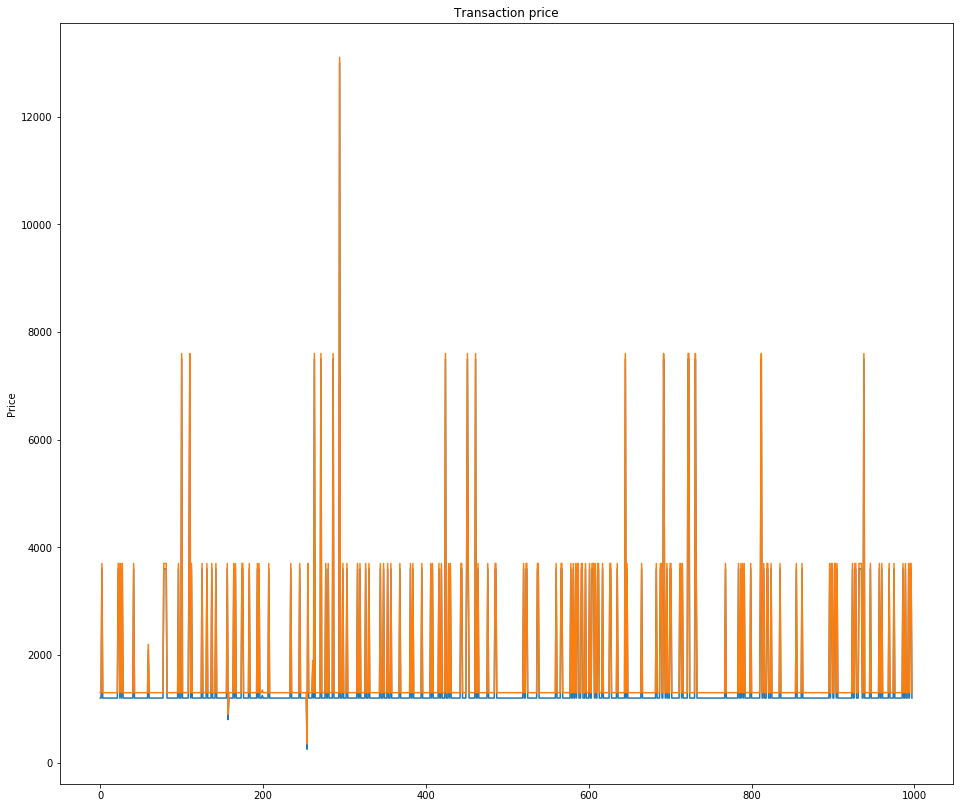

In [44]:
plt.figure(figsize=(16,14))
plt.plot(df.index, df['Price'])
plt.plot(df.index, df['price1'])
plt.title('Transaction price')
plt.ylabel('Price');
plt.show()
# plt.plot(df.index, df['price1'], 'r')
# plt.title('Transaction price')
# plt.ylabel('price1');
# plt.show()

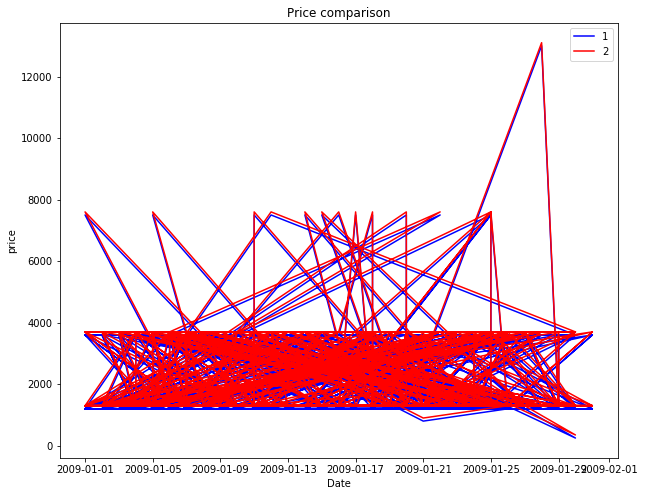

In [45]:
plt.figure(figsize=(10, 8))
plt.plot(df['date'], df['Price'], 'b-', label = '1')
plt.plot(df['date'], df['price1'], 'r-', label = '2')
plt.xlabel('Date'); plt.ylabel('price'); plt.title('Price comparison')
plt.legend();

In [30]:
#print(df['date'][1].dtype)
df['date1'].dtype

dtype('<M8[ns]')

In [12]:
df['date'][1].day #weekday_name#month #year

2

In [54]:
df2 = df.tail(10)
df2.shape

(10, 16)

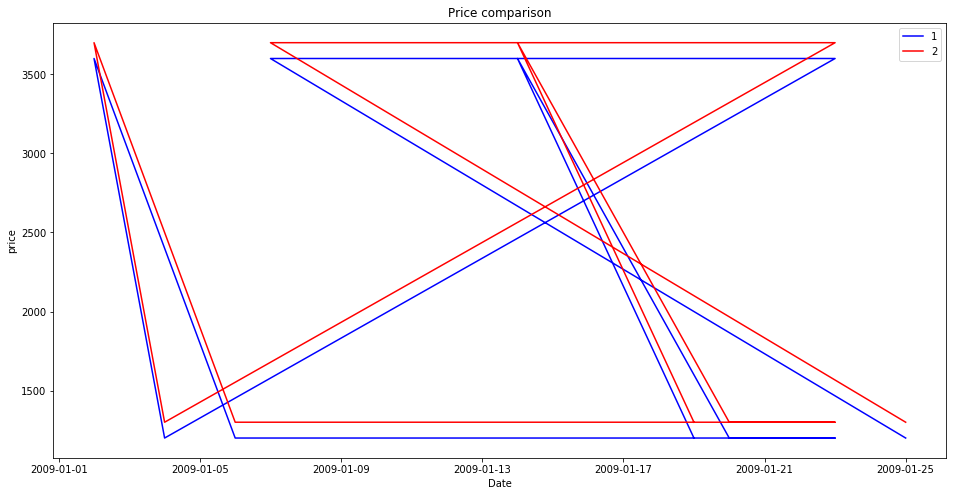

In [55]:
plt.figure(figsize=(16, 8))
plt.plot(df2['date'], df2['Price'], 'b-', label = '1')
plt.plot(df2['date'], df2['price1'], 'r-', label = '2')
plt.xlabel('Date'); plt.ylabel('price'); plt.title('Price comparison')
plt.legend();

<Figure size 360x360 with 0 Axes>

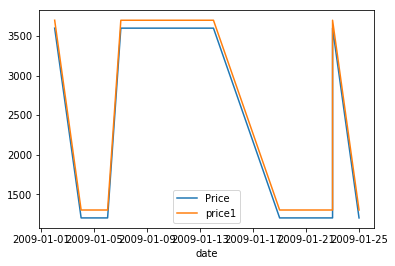

In [60]:
plt.figure(figsize=(5, 5))
df2.plot(x = 'date', y = ['Price', 'price1'])
#plt.plot(x = df['date'], y = df['Price'])

(array([733408., 733412., 733416., 733420., 733424., 733428., 733432.]),
 <a list of 7 Text xticklabel objects>)

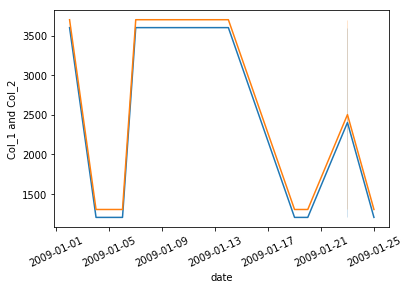

In [65]:
import seaborn as sns
#sns.set_theme(style="darkgrid")

sns.lineplot(x="date", y="Price",
             data=df2)
sns.lineplot(x = "date", y = "price1", data = df2) 
plt.ylabel("Col_1 and Col_2") 
plt.xticks(rotation = 25)